In [59]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')
print(f"GPU is available: {len(gpu_available) > 0}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0
GPU is available: True


In [60]:
# Imports:
import numpy as np
from scipy.linalg import solve
import pandas as pd
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(42)

In [61]:
# Read the CSV file into a DataFrame
matrix_data = pd.read_csv('SecondSmallestMatrixData(66).csv')
matrix_data = pd.DataFrame(matrix_data)
matrix_data = np.array(matrix_data)
matrix_data = matrix_data.astype(float)
print(matrix_data)

[[ 1.99033329e+03  5.67912180e+02  7.75783614e+02 ...  4.88975645e-03
   1.22115405e-02  1.16594521e-02]
 [ 5.67912180e+02  1.99033329e+03  7.75783614e+02 ...  1.22115405e-02
   4.88975645e-03  1.16594521e-02]
 [ 7.75783614e+02  7.75783614e+02  7.79706720e+03 ... -1.03177120e-03
  -1.03177120e-03 -2.20183612e-03]
 ...
 [ 4.88975645e-03  1.22115405e-02 -1.03177120e-03 ...  4.71321117e+03
   1.40760956e+00 -1.45663588e-15]
 [ 1.22115405e-02  4.88975645e-03 -1.03177120e-03 ...  1.40760956e+00
   4.71321117e+03 -3.14819011e-15]
 [ 1.16594521e-02  1.16594521e-02 -2.20183612e-03 ... -1.45663588e-15
  -3.14819011e-15  1.36307691e+03]]


In [62]:
# Pre-defined functions:

# Function to calculate sparsity and density
def calculate_sparsity_density(matrix, matrix_rows, matrix_columns):
    total_elements = matrix_rows * matrix_columns
    non_zero_elements = 0
    for row in range(matrix_rows):
        for column in range(matrix_columns):
            if matrix[row, column] != 0:
                non_zero_elements += 1

    zero_elements = total_elements - non_zero_elements
    sparsity = zero_elements / total_elements
    density = 1 - sparsity
    return sparsity, density


# Perform the matrix multiplication manually using GPU
def matrix_multiplication(A, B):
    with tf.device('/GPU:0'):
        A_tf = tf.convert_to_tensor(A, dtype=tf.float32)
        B_tf = tf.convert_to_tensor(B, dtype=tf.float32)
        result_tf = tf.matmul(A_tf, B_tf)
    return result_tf.numpy()


# Check if the matrix is symmetric
def is_symmetric(matrix):
    rows, cols = matrix.shape
    if (rows != cols):
        return False
    for i in range(rows):
        for j in range(cols):
            if (matrix[i, j] != matrix[j, i]):
                return False
    return True



# Calculate the determinant of the matrix using GPU
def calculate_determinant(matrix):
    with tf.device('/GPU:0'):
        matrix_tf = tf.convert_to_tensor(matrix, dtype=tf.float32)
        det_tf = tf.linalg.det(matrix_tf)
    return det_tf.numpy()


# Calculate the transpose of the matrix using GPU
def calculate_transpose(matrix):
    with tf.device('/GPU:0'):
        matrix_tf = tf.convert_to_tensor(matrix, dtype=tf.float32)
        transpose_tf = tf.transpose(matrix_tf)
    return transpose_tf.numpy()


# Calculate the inverse of the matrix using GPU
def get_matrix_minor(matrix, i, j):
    return np.delete(np.delete(matrix, i, axis=0), j, axis=1)

def get_matrix_cofactor(matrix):
    cofactor_matrix = np.zeros(matrix.shape)
    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            minor = get_matrix_minor(matrix, row, col)
            cofactor_matrix[row, col] = ((-1) ** (row + col)) * calculate_determinant(minor)
    return cofactor_matrix

def get_matrix_adjugate(matrix):
    cofactor_matrix = get_matrix_cofactor(matrix)
    return cofactor_matrix.T

def get_matrix_inverse(matrix):
    with tf.device('/GPU:0'):
        matrix_tf = tf.convert_to_tensor(matrix, dtype=tf.float32)
        inverse_tf = tf.linalg.inv(matrix_tf)
    return inverse_tf.numpy()


# Check if all the leading principal minors are non-zero
def leading_principal_minors_non_zero(matrix):
    n = len(matrix)
    for k in range(n, 0, -1):  # Iterate from the last element to the full matrix
        principal_minor = matrix[-k:, -k:]  # Extract bottom-right k x k submatrix
        determinant = calculate_determinant(principal_minor)
        print(f"Principal Minor of order {k}x{k}:\n{principal_minor}")
        print(f"Determinant: {determinant}\n")
        if determinant == 0:
            return False  # Return False if any determinant is zero
    return True


# Doolittle LU decomposition
def doolittle_lu_decomposition(matrix):
    n = len(matrix)
    L = np.zeros((n, n), dtype=float)
    U = np.zeros((n, n), dtype=float)

    for i in range(n):
        L[i][i] = 1.0
        for j in range(i, n):
            sum = 0.0
            for k in range(i):
                sum += L[i][k] * U[k][j]
            U[i][j] = matrix[i][j] - sum

        for j in range(i + 1, n):
            sum = 0.0
            for k in range(i):
                sum += L[j][k] * U[k][i]
            L[j][i] = (matrix[j][i] - sum) / U[i][i]

    return L, U


# Crout LU decomposition:
def crout_lu_decomposition(matrix):
    n = len(matrix)
    L = np.zeros((n, n), dtype=float)
    U = np.zeros((n, n), dtype=float)

    for j in range(n):
        U[j][j] = 1.0
        for i in range(j, n):
            sum = 0.0
            for k in range(j):
                sum += L[i][k] * U[k][j]
            L[i][j] = matrix[i][j] - sum

        for i in range(j + 1, n):
            sum = 0.0
            for k in range(j):
                sum += L[j][k] * U[k][i]
            U[j][i] = (matrix[j][i] - sum) / L[j][j]

    return L, U


# Check if all the leading principal minors are greater than zero
def leading_principal_minors_greaterThan_zero(matrix):
    n = len(matrix)
    for k in range(n, 0, -1):  # Iterate from the last element to the full matrix
        principal_minor = matrix[-k:, -k:]  # Extract bottom-right k x k submatrix
        determinant = calculate_determinant(principal_minor)
        print(f"Principal Minor of order {k}x{k}:\n{principal_minor}")
        print(f"Determinant: {determinant}\n")
        if determinant <= 0:
            return False  # Return False if any determinant is zero
    return True


# Check if all the entries on the diagonal are positive
def check_positive_diagonal(matrix):
    for i in range(len(matrix)):
        if matrix[i, i] <= 0:
            return False
    return True


# Check if the largest entry of the matrix is on the diagonal
def is_largest_element_on_diagonal(matrix):
    max_element = np.max(np.abs(matrix))
    for i in range(len(matrix)):
        if np.abs(matrix[i, i]) == max_element:
            return True
    return False


# Cholesky decomposition
def cholesky_decomposition(matrix):
    n = len(matrix)
    L = np.zeros_like(matrix)

    for i in range(n):
        for j in range(i + 1):
            sum_cholesky = 0
            for k in range(j):
                sum_cholesky += L[i][k] * L[j][k]
            if i == j:  # Diagonal elements
                L[i][j] = np.sqrt(matrix[i][i] - sum_cholesky)
            else:
                L[i][j] = (matrix[i][j] - sum_cholesky) / L[j][j]
    return L


# Generate a random banded matrix with specified lower and upper bandwidth
def generate_banded_matrix(size, lower_bandwidth, upper_bandwidth):
    matrix = np.zeros((size, size), dtype=int)
    for i in range(size):
        for j in range(max(0, i - lower_bandwidth), min(size, i + upper_bandwidth + 1)):
            matrix[i, j] = np.random.randint(1, 10)
    return matrix


# Check if the matrix is banded:
def is_banded(matrix, lower_bandwidth, upper_bandwidth):
    rows, cols = matrix.shape
    for i in range(rows):
        for j in range(cols):
            if (j < i - lower_bandwidth or j > i + upper_bandwidth) and matrix[i, j] != 0:
                return False
    return True


# Generata a Toeplitz matrix:
def generate_toeplitz_matrix(c, r):
    toeplitz_matrix = np.zeros((len(c), len(r)), dtype=int)
    for i in range(len(c)):
        for j in range(len(r)):
            if i >= j:
                toeplitz_matrix[i, j] = c[i - j]
            else:
                toeplitz_matrix[i, j] = r[j - i]
    return toeplitz_matrix


# Check if the matrix is Toeplitz:
def is_toeplitz(matrix):
    rows, cols = matrix.shape
    for i in range(1, rows):
        for j in range(1, cols):
            if matrix[i, j] != matrix[i - 1, j - 1]:
                return False
    return True


# Generate a random sparse matrix with a given sparsity:
def generate_sparse_matrix(size, sparsity):
    matrix = np.random.randint(1, 10, size=(size, size))
    zero_mask = np.random.rand(size, size) < sparsity
    matrix[zero_mask] = 0                            
    return matrix


# Plot Graph:
def plot_graph(matrix, title, cmap):
    plt.figure(figsize=(8, 8))  # Increased figure size for zoom
    plt.imshow(matrix, cmap=cmap, interpolation='nearest')
    plt.colorbar(label='Value', orientation='vertical', pad=0.02)
    plt.title(title, fontsize=16, color='black')
    plt.xlabel('Columns', fontsize=14, color='black')
    plt.ylabel('Rows', fontsize=14, color='black')
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')
    plt.grid(False)
    plt.gca().set_facecolor('white')
    plt.tight_layout()
    plt.show()

Information about the matrix:

Matrix A:
[[ 1.99033329e+03  5.67912180e+02  7.75783614e+02 ...  4.88975645e-03
   1.22115405e-02  1.16594521e-02]
 [ 5.67912180e+02  1.99033329e+03  7.75783614e+02 ...  1.22115405e-02
   4.88975645e-03  1.16594521e-02]
 [ 7.75783614e+02  7.75783614e+02  7.79706720e+03 ... -1.03177120e-03
  -1.03177120e-03 -2.20183612e-03]
 ...
 [ 4.88975645e-03  1.22115405e-02 -1.03177120e-03 ...  4.71321117e+03
   1.40760956e+00 -1.45663588e-15]
 [ 1.22115405e-02  4.88975645e-03 -1.03177120e-03 ...  1.40760956e+00
   4.71321117e+03 -3.14819011e-15]
 [ 1.16594521e-02  1.16594521e-02 -2.20183612e-03 ... -1.45663588e-15
  -3.14819011e-15  1.36307691e+03]]



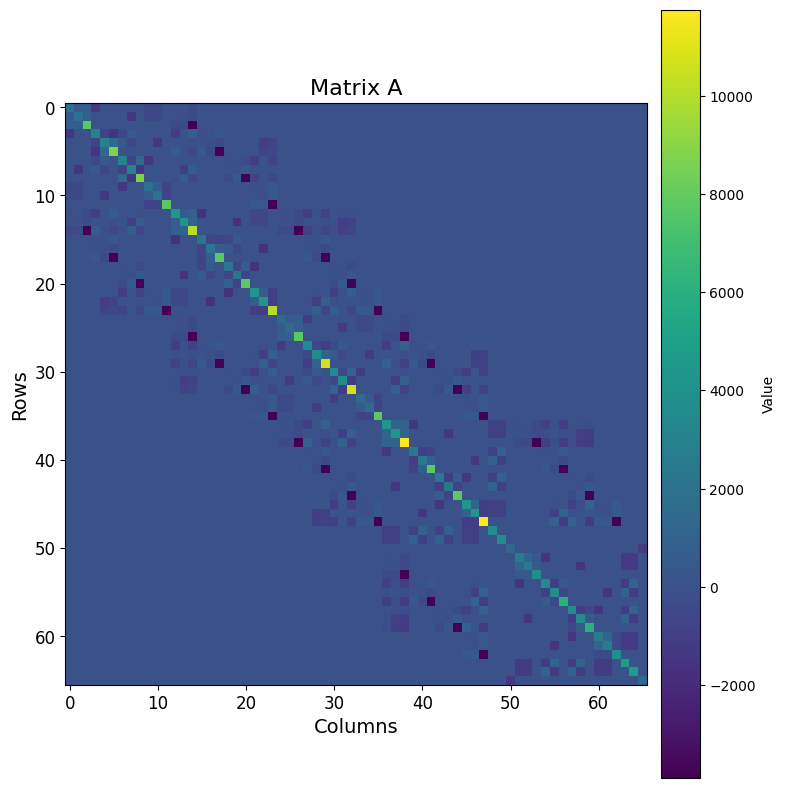

Number of rows: 66
Number of columns: 66
Dimensions: 66 x 66

The Matrix is Square: True

Sparsity: 0.0
Density: 1.0

The matrix is: DENSE.

Transpose of the Matrix A:
[[ 1.99033e+03  5.67910e+02  7.75780e+02 ...  0.00000e+00  1.00000e-02
   1.00000e-02]
 [ 5.67910e+02  1.99033e+03  7.75780e+02 ...  1.00000e-02  0.00000e+00
   1.00000e-02]
 [ 7.75780e+02  7.75780e+02  7.79707e+03 ... -0.00000e+00 -0.00000e+00
  -0.00000e+00]
 ...
 [ 0.00000e+00  1.00000e-02 -0.00000e+00 ...  4.71321e+03  1.41000e+00
  -0.00000e+00]
 [ 1.00000e-02  0.00000e+00 -0.00000e+00 ...  1.41000e+00  4.71321e+03
  -0.00000e+00]
 [ 1.00000e-02  1.00000e-02 -0.00000e+00 ... -0.00000e+00 -0.00000e+00
   1.36308e+03]]



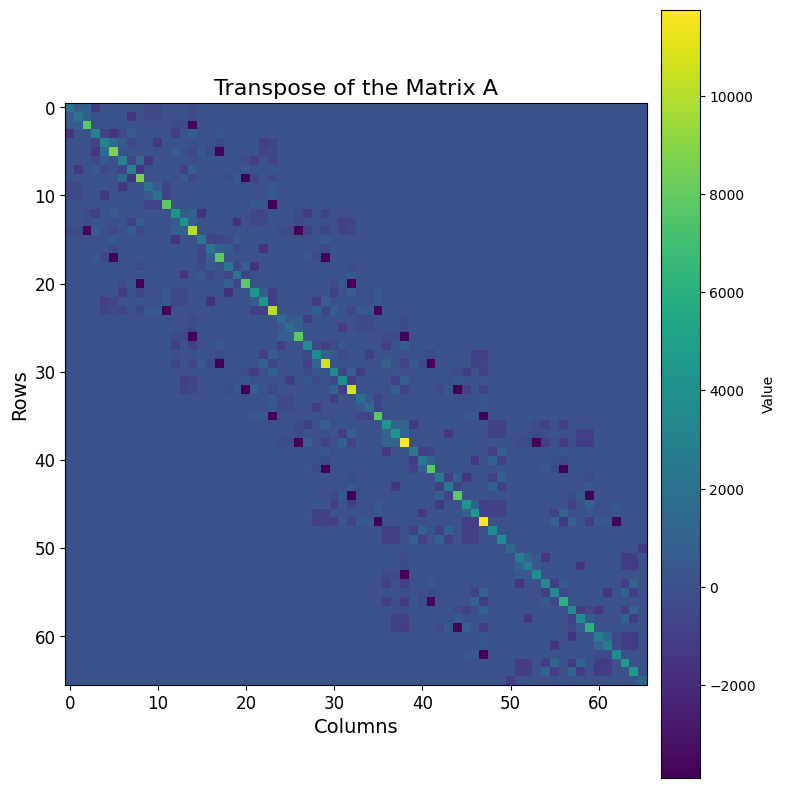

The Matrix is Symmetric: True

Determinant of the Matrix A: inf

The matrix is INVERTIBLE: True

Inverse of the Matrix A:
[[ 2.4069106e-02 -7.6201744e-03 -1.6094627e-03 ...  8.3916048e-03
   8.2097205e-05 -2.7230410e-06]
 [-7.6201796e-03  2.4069339e-02 -1.6094787e-03 ...  8.2091312e-05
   8.3918292e-03 -2.7226158e-06]
 [-1.6094628e-03 -1.6094792e-03  5.4703892e-04 ... -5.0756126e-04
  -5.0757552e-04  6.2657338e-05]
 ...
 [ 8.3916346e-03  8.2124803e-05 -5.0756533e-04 ...  1.0331892e-02
   3.3165221e-04  1.4767443e-10]
 [ 8.2040940e-05  8.3918078e-03 -5.0756958e-04 ...  3.3158617e-04
   1.0332085e-02 -4.5891357e-11]
 [-2.7232004e-06 -2.7228969e-06  6.2657367e-05 ... -3.4337930e-10
   4.9820269e-11  1.9020127e-02]]



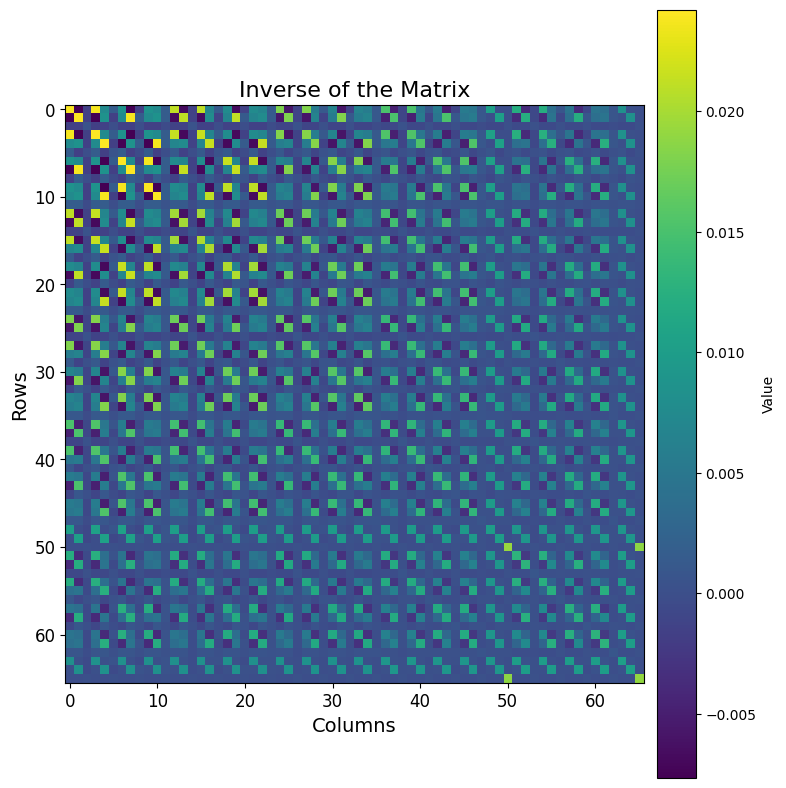

The Matrix is Toeplitz: False



In [63]:
# Information about the matrix:
print(f"Information about the matrix:\n")


# Display the matrix:
print(f"Matrix A:\n{matrix_data}\n") # Matrix 'A'
plot_graph(matrix_data, "Matrix A", "viridis")


# Number of rows in the matrix
matrix_rows = len(matrix_data)
print(f"Number of rows: {matrix_rows}")


# Number of columns in the matrix
matrix_columns = len(matrix_data[0])
print(f"Number of columns: {matrix_columns}")
print(f"Dimensions: {matrix_rows} x {matrix_columns}\n")


# Checking if the matrix is square:
is_matrix_square = (matrix_rows == matrix_columns)
print(f"The Matrix is Square: {is_matrix_square}\n")


# Checking the density and sparsity of the matrix:
matrix_sparsity, matrix_density = calculate_sparsity_density(matrix_data, matrix_rows, matrix_columns)
print(f"Sparsity: {np.round(matrix_sparsity, 2)}")
print(f"Density: {np.round(matrix_density, 2)}\n")

is_matrix_dense = False
is_matrix_sparse = False
if (matrix_density >= 0.5):
    is_matrix_dense = True
    print(f"The matrix is: DENSE.\n")
else:
    is_matrix_sparse = True
    print(f"The matrix is: SPARSE.\n")


# Calculating the Transpose of the matrix:
matrix_transpose = calculate_transpose(matrix_data)
print(f"Transpose of the Matrix A:\n{np.round(matrix_transpose, 2)}\n")
plot_graph(matrix_transpose, "Transpose of the Matrix A", "viridis")


# Checking if the matrix is symmetric:
is_matrix_symmetric = is_symmetric(matrix_data)
print(f"The Matrix is Symmetric: {is_matrix_symmetric}\n")


# Calculating the determinant of the matrix:
matrix_determinant = 0
if (is_matrix_square):
    matrix_determinant = calculate_determinant(matrix_data)
    print(f"Determinant of the Matrix A: {matrix_determinant}\n")


# Checking if the matrix is invertible:
is_matrix_invertible = False
matrix_inverse = None
if (matrix_determinant != 0):
    is_matrix_invertible = True
    print(f"The matrix is INVERTIBLE: {is_matrix_invertible}\n")
    matrix_inverse = get_matrix_inverse(matrix_data)
    print(f"Inverse of the Matrix A:\n{matrix_inverse}\n")
    plot_graph(matrix_inverse, "Inverse of the Matrix", "viridis")
else:
    print(f"The matrix is SINGULAR and cannot be inverted.\n")


# Checking if the matrix is Toeplitz:
is_matrix_toeplitz = is_toeplitz(matrix_data)
print(f"The Matrix is Toeplitz: {is_matrix_toeplitz}\n")

In [64]:
# Generating a temporary solution for the matrix:

# Solving the system of linear equations: AX = B
# Where A is matrix_data, X is the unit_matrix and B is the matrix_result;

unit_matrix = np.ones((matrix_columns, 1), dtype=float)
print("Unit matrix of order", matrix_columns, "x 1")
print(f"Matrix X:\n{unit_matrix}\n") # Matrix 'X'


# Multiplying the matrix_data with the unit_matrix to get the matrix_result('B'):
matrix_result = np.zeros((matrix_rows, 1), dtype=float)
matrix_result = matrix_multiplication(matrix_data, unit_matrix)
print(f"Matrix B:\n{matrix_result}\n") # Matrix 'B'


Unit matrix of order 66 x 1
Matrix X:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]

Matrix B:
[[ 4.8424344e+02]
 [ 4.8424362e+02]
 [ 4.6696016e+03]
 [-3.6815518e+02]
 [ 4.0734567e+02]
 [ 3.8974192e+03]
 [ 4.0734601e+02]
 [-3.6815527e+02]
 [ 3.8974180e+03]
 [-2.9137192e+02]
 [-2.9137192e+02]
 [ 3.1249607e+03]
 [-6.4068327e+00]
 [-6.4068918e+00]
 [ 9.4962662e-01]
 [-6.4467354e+00]
 [-5.2639475e+00]
 [-1.3005894e-01]
 [-5.2640357e+00]
 [-6.4469595e+00]
 [-1.2994015e-01]
 [-7.7978334e+00]
 [-7.7971716e+00]
 [-1.6509291e+00]
 [ 1.1358482e+00]
 [ 1.1359433e+00]
 [-3.2588601e-01]
 [ 1.6982759e+00]
 [ 1.4161426e+00]
 [ 7.1029246e-02]
 [ 1.4166387e+

Checking the Existence and Uniqueness of LU factorization:

Principal Minor of order 66x66:
[[ 1.99033329e+03  5.67912180e+02  7.75783614e+02 ...  4.88975645e-03
   1.22115405e-02  1.16594521e-02]
 [ 5.67912180e+02  1.99033329e+03  7.75783614e+02 ...  1.22115405e-02
   4.88975645e-03  1.16594521e-02]
 [ 7.75783614e+02  7.75783614e+02  7.79706720e+03 ... -1.03177120e-03
  -1.03177120e-03 -2.20183612e-03]
 ...
 [ 4.88975645e-03  1.22115405e-02 -1.03177120e-03 ...  4.71321117e+03
   1.40760956e+00 -1.45663588e-15]
 [ 1.22115405e-02  4.88975645e-03 -1.03177120e-03 ...  1.40760956e+00
   4.71321117e+03 -3.14819011e-15]
 [ 1.16594521e-02  1.16594521e-02 -2.20183612e-03 ... -1.45663588e-15
  -3.14819011e-15  1.36307691e+03]]
Determinant: inf

Principal Minor of order 65x65:
[[ 1.99033329e+03  7.75783614e+02  3.92057790e-01 ...  1.22115405e-02
   4.88975645e-03  1.16594521e-02]
 [ 7.75783614e+02  7.79706720e+03 -5.31350054e-02 ... -1.03177120e-03
  -1.03177120e-03 -2.20183612e-03]
 [ 3.9205779

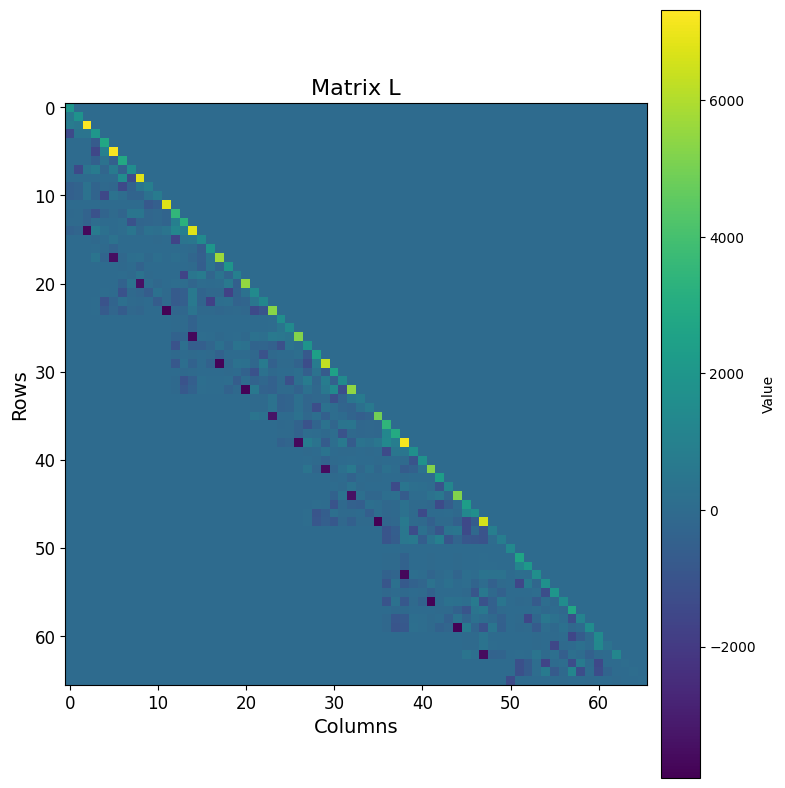

Matrix U:
[[ 1.    0.29  0.39 ...  0.    0.    0.  ]
 [ 0.    1.    0.3  ...  0.    0.    0.  ]
 [ 0.    0.    1.   ... -0.   -0.   -0.  ]
 ...
 [ 0.    0.    0.   ...  1.   -0.03 -0.  ]
 [ 0.    0.    0.   ...  0.    1.   -0.  ]
 [ 0.    0.    0.   ...  0.    0.    1.  ]]



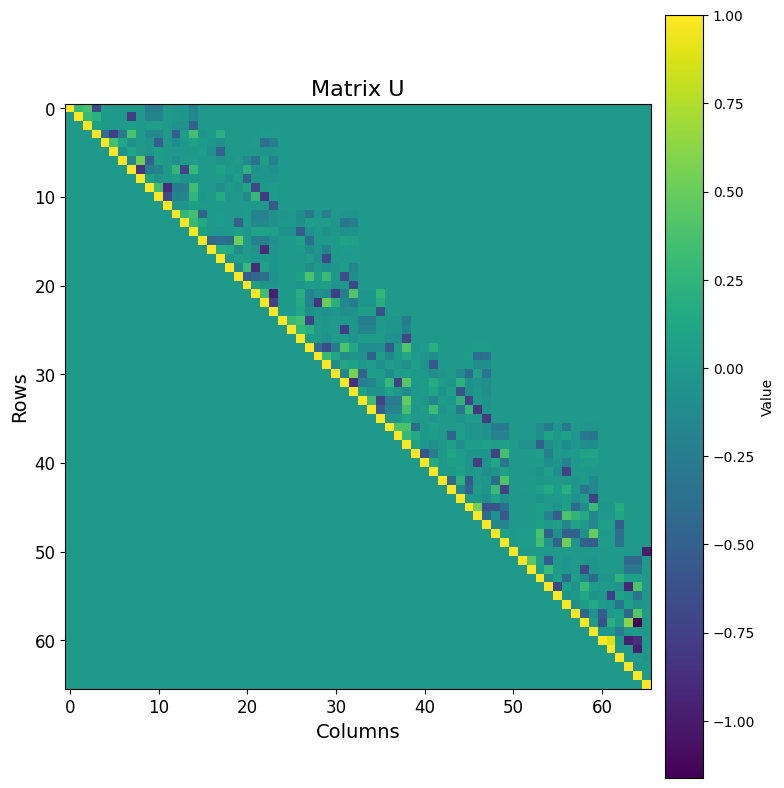

Matrix Y:
[[ 0.24]
 [ 0.19]
 [ 0.6 ]
 [-0.18]
 [ 0.1 ]
 [ 0.49]
 [ 0.18]
 [-0.29]
 [ 0.47]
 [-0.34]
 [-0.25]
 [ 0.4 ]
 [ 0.01]
 [ 0.01]
 [ 0.38]
 [-0.25]
 [ 0.01]
 [ 0.31]
 [ 0.06]
 [-0.28]
 [ 0.31]
 [-0.17]
 [-0.13]
 [ 0.28]
 [ 0.09]
 [ 0.07]
 [ 0.25]
 [ 0.06]
 [ 0.01]
 [ 0.27]
 [ 0.07]
 [-0.08]
 [ 0.23]
 [-0.14]
 [-0.11]
 [ 0.21]
 [ 0.01]
 [ 0.01]
 [ 0.17]
 [-0.09]
 [ 0.  ]
 [ 0.18]
 [ 0.04]
 [-0.09]
 [ 0.17]
 [ 0.02]
 [ 0.01]
 [ 0.18]
 [ 0.07]
 [ 0.06]
 [ 0.  ]
 [ 0.02]
 [ 0.02]
 [ 0.39]
 [ 0.1 ]
 [ 0.05]
 [ 0.81]
 [ 0.03]
 [ 0.09]
 [ 0.71]
 [ 0.02]
 [ 0.01]
 [ 0.99]
 [ 0.97]
 [ 1.  ]
 [ 1.  ]]

The solution of the system of linear equations is:

Matrix X:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [

In [65]:
# Now Calculating the solution of the system of linear equations using LU factorization in various situations:

# 1. When the matrix is Square and Dense:
if(is_matrix_square and is_matrix_dense):
    print(f"Checking the Existence and Uniqueness of LU factorization:\n")


    # Checking if all the principal minors are non-zero:
    all_principal_minors_non_zero = leading_principal_minors_non_zero(matrix_data)
    print(f"All Principal Minors are Non-Zero: {all_principal_minors_non_zero}\n")

    if (all_principal_minors_non_zero and matrix_determinant!=0):
        print(f"LU factorization exists and is unique.\n")

        print("LU factorization of the matrix_data('A'):\n")
        factorization_method = input("Choose the method for LU factorization (doolittle/crout): ").strip().lower()

        if (factorization_method == 'doolittle'):
            matrix_L, matrix_U = doolittle_lu_decomposition(matrix_data)
        elif (factorization_method == 'crout'):
            matrix_L, matrix_U = crout_lu_decomposition(matrix_data)
        else:
            raise ValueError("Invalid method chosen. Please choose either 'doolittle' or 'crout'.")
        
        print(f"Matrix L:\n{np.round(matrix_L, 2)}\n")
        plot_graph(matrix_L, "Matrix L", "viridis")

        print(f"Matrix U:\n{np.round(matrix_U, 2)}\n")
        plot_graph(matrix_U, "Matrix U", "viridis")


        # Now solving the system of linear equations using LU factorization:
        # Solving LY = B, where Y = UX
        matrix_Y = solve(matrix_L, matrix_result)
        print(f"Matrix Y:\n{np.round(matrix_Y, 2)}\n")

        # Solving UX = Y
        matrix_X = solve(matrix_U, matrix_Y)
        print(f"The solution of the system of linear equations is:\n")
        print(f"Matrix X:\n{np.round(matrix_X, 2)}\n")


        # Calculating the determinant of the matrix_L and matrix_U:
        determinana_matrix_L = calculate_determinant(matrix_L)
        print(f"Determinant of the matrix L: {determinana_matrix_L}\n")

        determinana_matrix_U = calculate_determinant(matrix_U)
        print(f"Determinant of the matrix U: {determinana_matrix_U}\n")

        if (factorization_method == 'doolittle'):
            print(f"The determinant of matrix_data('A') is equal to the determinant of U. And the determinant of L is 1.\n")
        elif (factorization_method == 'crout'):
            print(f"The determinant of matrix_data('A') is equal to the determinant of L. And the determinant of U is 1.\n")

    else:
        print(f"LU factorization does not exist.\n")

Checking if the matrix_data('A') is Positive Definite:

Principal Minor of order 66x66:
[[ 1.99033329e+03  5.67912180e+02  7.75783614e+02 ...  4.88975645e-03
   1.22115405e-02  1.16594521e-02]
 [ 5.67912180e+02  1.99033329e+03  7.75783614e+02 ...  1.22115405e-02
   4.88975645e-03  1.16594521e-02]
 [ 7.75783614e+02  7.75783614e+02  7.79706720e+03 ... -1.03177120e-03
  -1.03177120e-03 -2.20183612e-03]
 ...
 [ 4.88975645e-03  1.22115405e-02 -1.03177120e-03 ...  4.71321117e+03
   1.40760956e+00 -1.45663588e-15]
 [ 1.22115405e-02  4.88975645e-03 -1.03177120e-03 ...  1.40760956e+00
   4.71321117e+03 -3.14819011e-15]
 [ 1.16594521e-02  1.16594521e-02 -2.20183612e-03 ... -1.45663588e-15
  -3.14819011e-15  1.36307691e+03]]
Determinant: inf

Principal Minor of order 65x65:
[[ 1.99033329e+03  7.75783614e+02  3.92057790e-01 ...  1.22115405e-02
   4.88975645e-03  1.16594521e-02]
 [ 7.75783614e+02  7.79706720e+03 -5.31350054e-02 ... -1.03177120e-03
  -1.03177120e-03 -2.20183612e-03]
 [ 3.92057790e-0

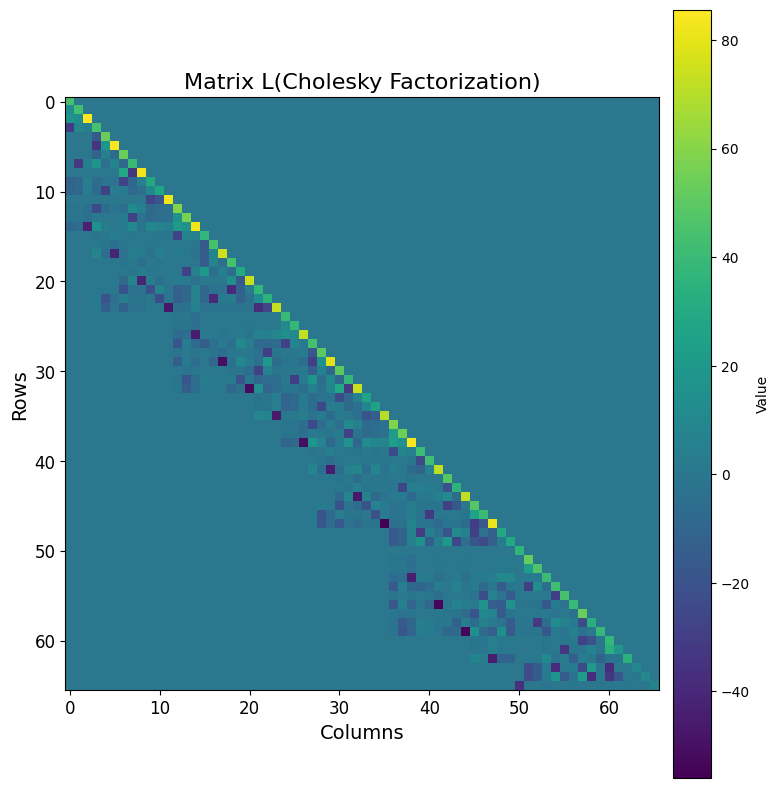

Matrix L(Transpose[L^T]):
[[44.61 12.73 17.39 ...  0.    0.    0.  ]
 [ 0.   42.76 12.97 ...  0.    0.    0.  ]
 [ 0.    0.   85.6  ... -0.   -0.   -0.  ]
 ...
 [ 0.    0.    0.   ...  9.84 -0.32 -0.  ]
 [ 0.    0.    0.   ...  0.    9.84  0.  ]
 [ 0.    0.    0.   ...  0.    0.    7.25]]

Matrix Y(Cholesky Factorization):
[[ 10.85]
 [  8.09]
 [ 51.12]
 [ -8.01]
 [  5.28]
 [ 41.49]
 [  9.84]
 [-11.25]
 [ 39.24]
 [ -9.92]
 [ -7.06]
 [ 33.26]
 [  0.6 ]
 [  0.46]
 [ 31.44]
 [ -9.32]
 [  0.54]
 [ 23.05]
 [  2.63]
 [ -8.55]
 [ 22.8 ]
 [ -6.43]
 [ -4.53]
 [ 20.39]
 [  3.5 ]
 [  2.62]
 [ 18.29]
 [  2.75]
 [  0.3 ]
 [ 21.22]
 [  3.62]
 [ -2.97]
 [ 16.78]
 [ -3.73]
 [ -2.67]
 [ 15.04]
 [  0.61]
 [  0.41]
 [ 14.65]
 [ -3.69]
 [  0.16]
 [ 12.93]
 [  1.85]
 [ -3.06]
 [ 12.23]
 [  0.73]
 [  0.39]
 [ 14.79]
 [  2.  ]
 [  1.85]
 [  0.08]
 [  1.23]
 [  0.77]
 [ 15.79]
 [  4.29]
 [  2.27]
 [ 32.1 ]
 [  1.7 ]
 [  3.04]
 [ 27.69]
 [  0.69]
 [  0.17]
 [ 34.99]
 [  9.53]
 [  9.84]
 [  7.25]]

The solution 

In [66]:
# 2. When the matrix is Square and Symmetric:
if (is_matrix_square and is_matrix_symmetric):
    print("Checking if the matrix_data('A') is Positive Definite:\n")


    # Checking if all the principal minors are greater than zero:
    all_principal_minors_greaterThan_zero = leading_principal_minors_greaterThan_zero(matrix_data)
    print(f"All Principal Minors are Greater than Zero: {all_principal_minors_greaterThan_zero}\n")

    # Checking if all the entries on the diagonal are positive:
    diagonal_values_positive = check_positive_diagonal(matrix_data)
    print(f"All the entries on the diagonal are Positive: {diagonal_values_positive}\n")

    # Checking if the largest element of the matrix is on the diagonal:
    largest_element_on_diagonal = is_largest_element_on_diagonal(matrix_data)

    # Calculating the Eigenvalues of the matrix:
    eigenvalues = np.linalg.eigvals(matrix_data) # eigenvalues, _ = np.linalg.eig(matrix_data)

    # Checking if all the eigenvalues are positive:
    all_eigenvalues_positive = True
    for eigenvalue in eigenvalues:
        if eigenvalue <= 0:
            all_eigenvalues_positive = False
            break
    print(f"All the Eigenvalues are Positive: {all_eigenvalues_positive}\n")


    if (all_eigenvalues_positive and all_principal_minors_greaterThan_zero and diagonal_values_positive and largest_element_on_diagonal):
        print(f"The matrix_data('A') is SYMMETRIC POSITIVE DEFINITE(SPD).\n")
        print(f"Now applying Cholesky Factorization to find the solution of the system of linear equations:\n")

        matrix_L_cholesky = cholesky_decomposition(matrix_data)
        print(f"Matrix L(Cholesky Factorization):\n{np.round(matrix_L_cholesky, 2)}\n")
        plot_graph(matrix_L_cholesky, "Matrix L(Cholesky Factorization)", "viridis")

        matrix_L_cholesky_transpose = calculate_transpose(matrix_L_cholesky)
        print(f"Matrix L(Transpose[L^T]):\n{np.round(matrix_L_cholesky_transpose, 2)}\n")


        # Now solving the system of linear equations using Cholesky Factorization:
        # Solving LY = B, where Y = [L^T]X
        matrix_Y_cholesky = solve(matrix_L_cholesky, matrix_result)
        print(f"Matrix Y(Cholesky Factorization):\n{np.round(matrix_Y_cholesky, 2)}\n")

        # Solving [L^T]X = Y
        matrix_X_cholesky = solve(matrix_L_cholesky_transpose, matrix_Y_cholesky)
        print(f"The solution of the system of linear equations is:\n")
        print(f"Matrix X(Cholesky Factorization):\n{np.round(matrix_X_cholesky, 2)}\n")

        # Difference between the solutions obtained from LU and Cholesky factorization:
        matrix_difference = matrix_X_cholesky - unit_matrix
        print(f"Difference between the solutions obtained from LU and Cholesky factorization:\n{np.round(matrix_difference, 2)}\n")
    
    else:
        print(f"The matrix_data('A') is NOT SYMMETRIC POSITIVE DEFINITE(SPD).\n")





In [67]:
# 3. When the matrix is Square and Banded:


In [68]:
# 4. When the matrix is Square and Sparse:
if (is_matrix_square and is_matrix_sparse):
    print(f"Checking the Existence and Uniqueness of LU factorization for Sparse Matrix:\n")
    
    
    # Checking if all the principal minors are non-zero:
    all_principal_minors_non_zero = leading_principal_minors_non_zero(matrix_data)
    print(f"All Principal Minors are Non-Zero: {all_principal_minors_non_zero}\n")

    if (all_principal_minors_non_zero and matrix_determinant!=0):
        print(f"LU factorization for Sparse Matrix exists and is unique.\n")

        print("LU factorization of the matrix_data('A'):\n")
        factorization_method = input("Choose the method for LU factorization (doolittle/crout): ").strip().lower()

        if (factorization_method == 'doolittle'):
            matrix_L_sparse, matrix_U_sparse = doolittle_lu_decomposition(matrix_data)
        elif (factorization_method == 'crout'):
            matrix_L_sparse, matrix_U_sparse = crout_lu_decomposition(matrix_data)
        else:
            raise ValueError("Invalid method chosen. Please choose either 'doolittle' or 'crout'.")
        
        print(f"Matrix L(Sparse):\n{np.round(matrix_L_sparse, 2)}\n")
        plot_graph(matrix_L_sparse, "Matrix L(Sparse)", "viridis")

        print(f"Matrix U(Sparse):\n{np.round(matrix_U_sparse, 2)}\n")
        plot_graph(matrix_U_sparse, "Matrix U(Sparse)", "viridis")

        # Now solving the system of linear equations using LU factorization:
        # Solving LY = B, where Y = UX
        matrix_Y_sparse = solve(matrix_L_sparse, matrix_result)
        print(f"Matrix Y(Sparse):\n{np.round(matrix_Y_sparse, 2)}\n")

        # Solving UX = Y
        matrix_X_sparse = solve(matrix_U_sparse, matrix_Y_sparse)
        print(f"The solution of the system of linear equations is:\n")
        print(f"Matrix X(Sparse):\n{np.round(matrix_X_sparse, 2)}\n")

        # Calculating the determinant of the matrix_L_sparse and matrix_U_sparse:
        determinana_matrix_L_sparse = calculate_determinant(matrix_L_sparse)
        print(f"Determinant of the matrix L(Sparse): {determinana_matrix_L_sparse}\n")

        determinana_matrix_U_sparse = calculate_determinant(matrix_U_sparse)
        print(f"Determinant of the matrix U(Sparse): {determinana_matrix_U_sparse}\n")

        if (factorization_method == 'doolittle'):
            print(f"The determinant of matrix_data('A') is equal to the determinant of U. And the determinant of L is 1.\n")
        elif (factorization_method == 'crout'):
            print(f"The determinant of matrix_data('A') is equal to the determinant of L. And the determinant of U is 1.\n")
            
    else:
        print(f"LU factorization does not exist.\n")


Matrix One:
[[52 89 60 ... 24 26 89]
 [93 52 89 ... 53 24 26]
 [15 93 52 ... 82 53 24]
 ...
 [73 21  7 ... 52 89 60]
 [39 73 21 ... 93 52 89]
 [18 39 73 ... 15 93 52]]



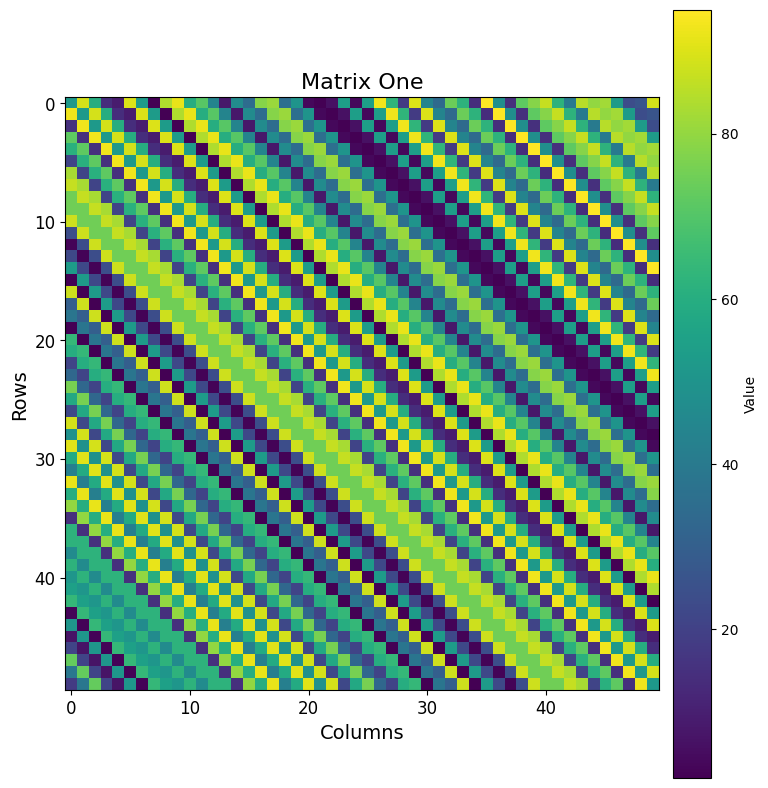

Determinant of the Matrix One: inf

Matrix Two:
[[60 15 90 ... 27  9 62]
 [41 60 15 ... 72 27  9]
 [29 41 60 ... 70 72 27]
 ...
 [14 90  5 ... 60 15 90]
 [27 14 90 ... 41 60 15]
 [ 9 27 14 ... 29 41 60]]



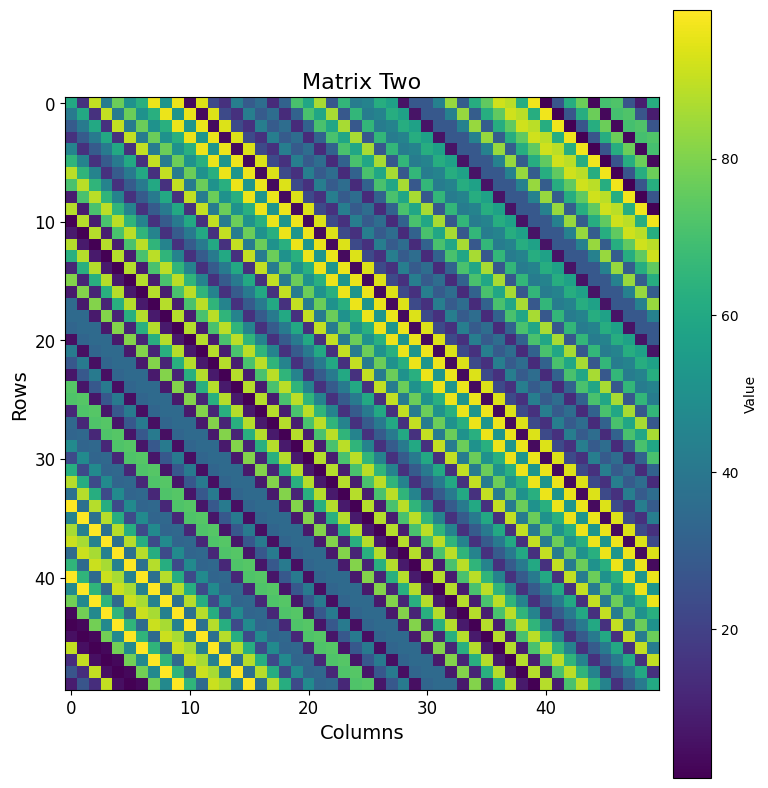

The Matrix One is Toeplitz: True

The Matrix Two is Toeplitz: True

Product of Two Toeplitz Matrices:
[[108986. 121581. 125912. ... 143185. 136700. 129160.]
 [124887. 109580. 127548. ... 135248. 141441. 138817.]
 [114286. 124878. 110228. ... 129307. 134629. 141305.]
 ...
 [112845. 117252. 127505. ... 130894. 135563. 133876.]
 [111844. 112890. 119142. ... 136777. 129505. 135521.]
 [110608. 111313. 112107. ... 135240. 134358. 126972.]]



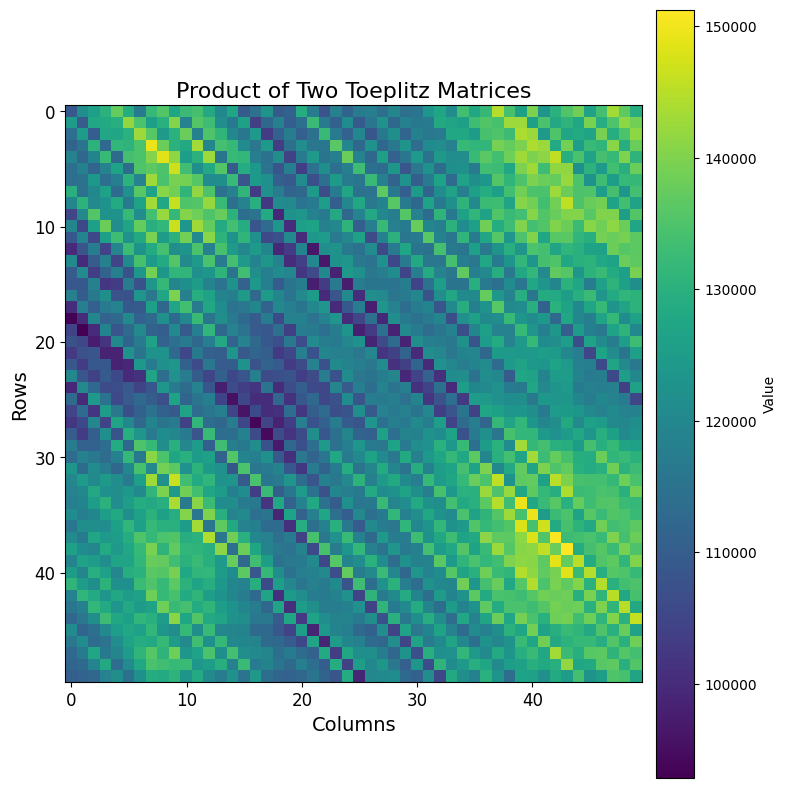

The Product of Two Toeplitz Matrices is Toeplitz: False
Inverse of the Matrix One:
[[ 0.03389192 -0.01075425  0.01281001 ...  0.00949055  0.00224668
  -0.02784   ]
 [ 0.00222145  0.00456932  0.00509863 ... -0.0104138  -0.00801304
   0.00224668]
 [-0.02148783  0.01134919 -0.00476393 ... -0.00875651 -0.01041378
   0.00949056]
 ...
 [-0.01967142  0.00730411 -0.0085925  ... -0.00476393  0.00509863
   0.01281002]
 [ 0.01827685 -0.01230299  0.00730411 ...  0.0113492   0.00456932
  -0.01075425]
 [-0.03483868  0.01827685 -0.01967142 ... -0.02148783  0.00222145
   0.03389192]]



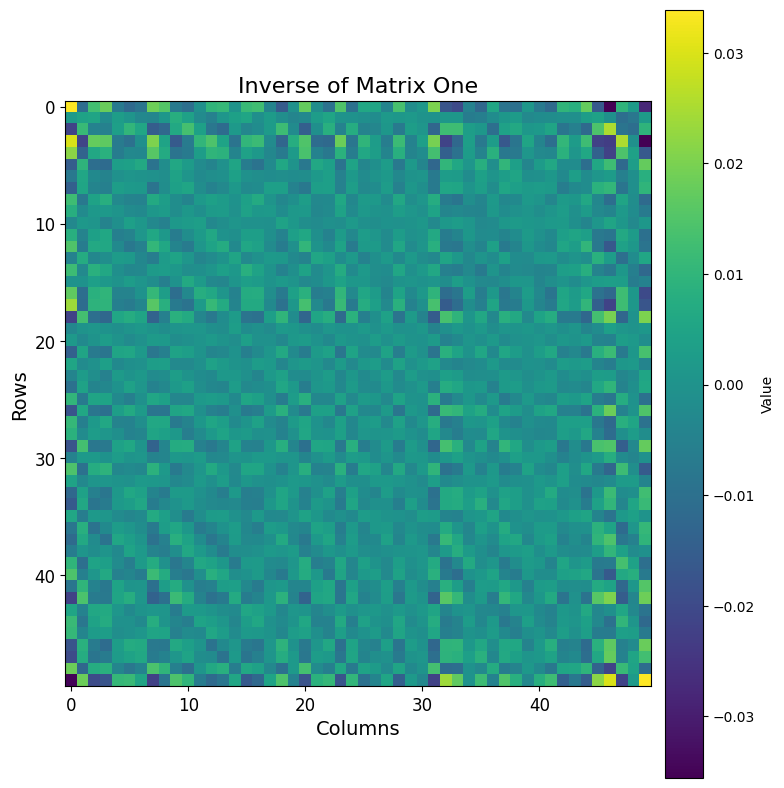

The Inverse of the Matrix One is Toeplitz: False

Transpose of the Matrix One:
[[52. 93. 15. ... 73. 39. 18.]
 [89. 52. 93. ... 21. 73. 39.]
 [60. 89. 52. ...  7. 21. 73.]
 ...
 [24. 53. 82. ... 52. 93. 15.]
 [26. 24. 53. ... 89. 52. 93.]
 [89. 26. 24. ... 60. 89. 52.]]



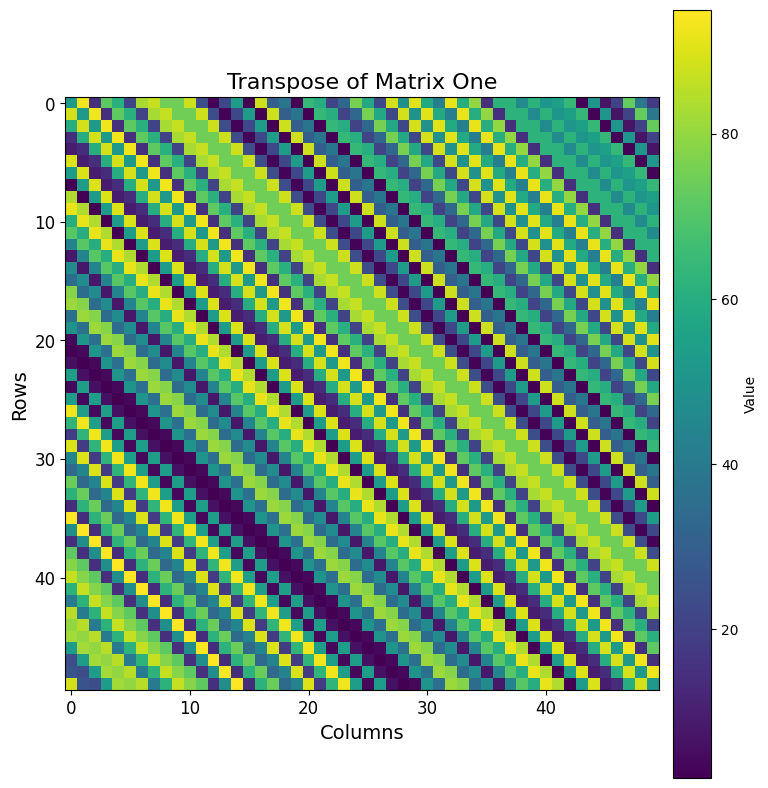

The Transpose of the Matrix One is Toeplitz: True

Checking the Existence and Uniqueness of LU factorization for Toeplitz Matrix:

Principal Minor of order 50x50:
[[52 89 60 ... 24 26 89]
 [93 52 89 ... 53 24 26]
 [15 93 52 ... 82 53 24]
 ...
 [73 21  7 ... 52 89 60]
 [39 73 21 ... 93 52 89]
 [18 39 73 ... 15 93 52]]
Determinant: inf

Principal Minor of order 49x49:
[[52 89 60 ... 53 24 26]
 [93 52 89 ... 82 53 24]
 [15 93 52 ... 80 82 53]
 ...
 [21  7 51 ... 52 89 60]
 [73 21  7 ... 93 52 89]
 [39 73 21 ... 15 93 52]]
Determinant: inf

Principal Minor of order 48x48:
[[52 89 60 ... 82 53 24]
 [93 52 89 ... 80 82 53]
 [15 93 52 ... 85 80 82]
 ...
 [ 7 51  3 ... 52 89 60]
 [21  7 51 ... 93 52 89]
 [73 21  7 ... 15 93 52]]
Determinant: inf

Principal Minor of order 47x47:
[[52 89 60 ... 80 82 53]
 [93 52 89 ... 85 80 82]
 [15 93 52 ... 40 85 80]
 ...
 [51  3 64 ... 52 89 60]
 [ 7 51  3 ... 93 52 89]
 [21  7 51 ... 15 93 52]]
Determinant: -inf

Principal Minor of order 46x46:
[[52 89 60 .

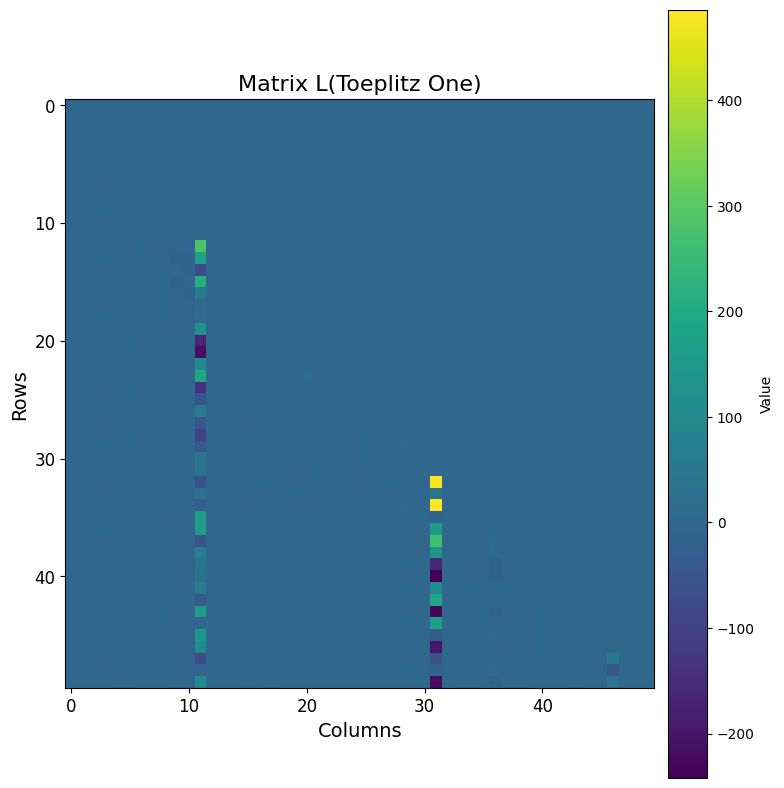

Matrix U(Toeplitz One):
[[   52.      89.      60.   ...    24.      26.      89.  ]
 [    0.    -107.17   -18.31 ...    10.08   -22.5   -133.17]
 [    0.       0.      23.19 ...    81.41    31.37   -85.33]
 ...
 [    0.       0.       0.   ... -3322.33  2682.82  2107.02]
 [    0.       0.       0.   ...     0.     189.6     60.16]
 [    0.       0.       0.   ...     0.       0.      29.51]]



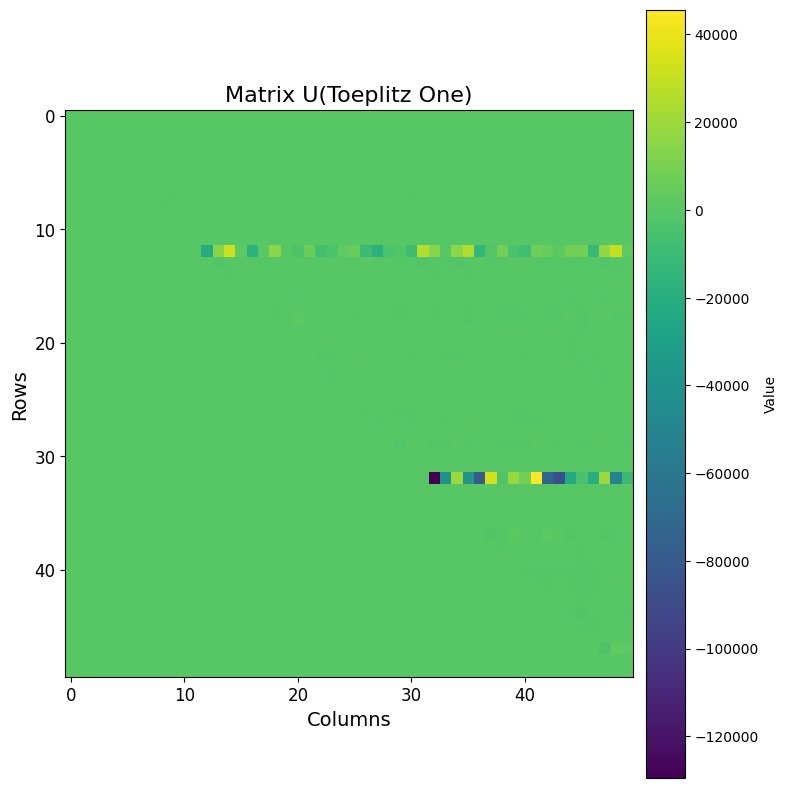

Matrix Y(Toeplitz One):
[[ 2.6070000e+03]
 [-2.0515200e+03]
 [ 5.5920000e+02]
 [ 4.2500000e+02]
 [ 2.3605800e+03]
 [-1.8545000e+02]
 [ 5.0215000e+02]
 [ 4.6785000e+02]
 [-6.8313000e+02]
 [-8.2484000e+02]
 [-6.4566000e+02]
 [-4.2421000e+02]
 [ 1.1309025e+05]
 [-9.2488600e+03]
 [-1.7589900e+03]
 [-3.6196000e+02]
 [ 1.4862500e+03]
 [-1.9769300e+03]
 [-2.9370000e+03]
 [-3.1476000e+02]
 [ 2.2194000e+02]
 [-8.6400000e+01]
 [-5.6015000e+02]
 [ 5.6421000e+02]
 [ 5.0535000e+02]
 [ 1.2103000e+02]
 [-7.2820000e+01]
 [ 3.5399000e+02]
 [ 1.2241600e+03]
 [-5.4941600e+03]
 [ 9.2514000e+02]
 [ 8.6298000e+02]
 [-4.1353611e+05]
 [-9.1000000e-01]
 [-3.2170000e+01]
 [ 1.1790000e+02]
 [ 1.6735000e+02]
 [-1.4189100e+03]
 [-3.3846000e+02]
 [-5.9118000e+02]
 [-3.1239200e+03]
 [-2.8491900e+03]
 [-2.1344200e+03]
 [-3.9539000e+02]
 [-2.0588700e+03]
 [-7.4090000e+02]
 [-2.5790000e+01]
 [ 1.4675200e+03]
 [ 2.4976000e+02]
 [ 2.9510000e+01]]

The solution of the system of linear equations is:

Matrix X(Toeplitz One)

In [69]:
# 5. When the matrix is Square and Toeplitz:
if (is_matrix_square and is_matrix_toeplitz):
    print(f"Matrix A:\n{matrix_data}\n") # Matrix 'A'
    plot_graph(matrix_data, "Matrix A(Toeplitz)", "viridis")
    
    print(f"Transpose of the Matrix A:\n{np.round(matrix_transpose, 2)}\n")
    plot_graph(matrix_transpose, "Transpose of Matrix A(Toeplitz)", "viridis")

    print(f"Inverse of the Matrix A:\n{matrix_inverse}\n")
    plot_graph(matrix_inverse, "Inverse of Matrix A(Toeplitz)", "viridis")

    print(f"Checking the Existence and Uniqueness of LU factorization for Toeplitz Matrix:\n")

    all_principal_minors_non_zero = leading_principal_minors_non_zero(matrix_data)
    print(f"All Principal Minors are Non-Zero: {all_principal_minors_non_zero}\n")

    if (all_principal_minors_non_zero and matrix_determinant!=0):
        print(f"LU factorization for Toeplitz Matrix exists and is unique.\n")

        print("LU factorization of the matrix_data('A'):\n")
        factorization_method = input("Choose the method for LU factorization (doolittle/crout): ").strip().lower()

        if (factorization_method == 'doolittle'):
            matrix_L_toeplitz, matrix_U_toeplitz = doolittle_lu_decomposition(matrix_data)
        elif (factorization_method == 'crout'):
            matrix_L_toeplitz, matrix_U_toeplitz = crout_lu_decomposition(matrix_data)
        else:
            raise ValueError("Invalid method chosen. Please choose either 'doolittle' or 'crout'.")

        print(f"Matrix L(Toeplitz):\n{np.round(matrix_L_toeplitz, 2)}\n")
        plot_graph(matrix_L_toeplitz, "Matrix L(Toeplitz)", "viridis")

        print(f"Matrix U(Toeplitz):\n{np.round(matrix_U_toeplitz, 2)}\n")
        plot_graph(matrix_U_toeplitz, "Matrix U(Toeplitz)", "viridis")

        # Now solving the system of linear equations using LU factorization:
        # Solving LY = B, where Y = UX
        matrix_Y_toeplitz = solve(matrix_L_toeplitz, matrix_result)
        print(f"Matrix Y(Toeplitz):\n{np.round(matrix_Y_toeplitz, 2)}\n")

        # Solving UX = Y
        matrix_X_toeplitz = solve(matrix_U_toeplitz, matrix_Y_toeplitz)
        print(f"The solution of the system of linear equations is:\n")
        print(f"Matrix X(Toeplitz):\n{np.round(matrix_X_toeplitz, 2)}\n")

        # Calculating the determinant of the matrix_L_toeplitz and matrix_U_toeplitz:
        determinana_matrix_L_toeplitz = calculate_determinant(matrix_L_toeplitz)
        print(f"Determinant of the matrix L(Toeplitz): {determinana_matrix_L_toeplitz}\n")

        determinana_matrix_U_toeplitz = calculate_determinant(matrix_U_toeplitz)
        print(f"Determinant of the matrix U(Toeplitz): {determinana_matrix_U_toeplitz}\n")

        if (factorization_method == 'doolittle'):
            print(f"The determinant of matrix_data('A') is equal to the determinant of U. And the determinant of L is 1.\n")
        elif (factorization_method == 'crout'):
            print(f"The determinant of matrix_data('A') is equal to the determinant of L. And the determinant of U is 1.\n")
    
    else:
        print(f"LU factorization does not exist.\n")

else:
    # Generating random Toeplitz Matrix:

    # Matrix 1:
    c1 = np.random.randint(1, 100, size=50)
    r1 = np.random.randint(1, 100, size=50)
    matrix_toeplitz_one = generate_toeplitz_matrix(c1, r1)
    print(f"Matrix One:\n{matrix_toeplitz_one}\n") # Matrix 1
    plot_graph(matrix_toeplitz_one, "Matrix One", "viridis")

    matrix_toeplitz_one_determinant = calculate_determinant(matrix_toeplitz_one)
    print(f"Determinant of the Matrix One: {matrix_toeplitz_one_determinant}\n")

    # Matrix 2:
    c2 = np.random.randint(1, 100, size=50)
    r2 = np.random.randint(1, 100, size=50)
    matrix_toeplitz_two = generate_toeplitz_matrix(c2, r2)
    print(f"Matrix Two:\n{matrix_toeplitz_two}\n")
    plot_graph(matrix_toeplitz_two, "Matrix Two", "viridis")

    is_matrix_toeplitz_one = is_toeplitz(matrix_toeplitz_one)
    print(f"The Matrix One is Toeplitz: {is_matrix_toeplitz_one}\n")

    is_matrix_toeplitz_two = is_toeplitz(matrix_toeplitz_two)
    print(f"The Matrix Two is Toeplitz: {is_matrix_toeplitz_two}\n")

    if (is_matrix_toeplitz_one and is_matrix_toeplitz_two):
        matrix_toeplitz_one_matrix_toeplitz_two_product = matrix_multiplication(matrix_toeplitz_one, matrix_toeplitz_two)
        print(f"Product of Two Toeplitz Matrices:\n{matrix_toeplitz_one_matrix_toeplitz_two_product}\n")
        plot_graph(matrix_toeplitz_one_matrix_toeplitz_two_product, "Product of Two Toeplitz Matrices", "viridis")
        is_matrix_toeplitz_one_matrix_toeplitz_two_product = is_toeplitz(matrix_toeplitz_one_matrix_toeplitz_two_product)
        print("The Product of Two Toeplitz Matrices is Toeplitz:", is_matrix_toeplitz_one_matrix_toeplitz_two_product)


        matrix_toeplitz_one_inverse = get_matrix_inverse(matrix_toeplitz_one)
        print(f"Inverse of the Matrix One:\n{matrix_toeplitz_one_inverse}\n")
        plot_graph(matrix_toeplitz_one_inverse, "Inverse of Matrix One", "viridis")
        is_matrix_toeplitz_one_inverse = is_toeplitz(matrix_toeplitz_one_inverse)
        print(f"The Inverse of the Matrix One is Toeplitz: {is_matrix_toeplitz_one_inverse}\n")


        matrix_toeplitz_one_transpose = calculate_transpose(matrix_toeplitz_one)
        print(f"Transpose of the Matrix One:\n{matrix_toeplitz_one_transpose}\n")
        plot_graph(matrix_toeplitz_one_transpose, "Transpose of Matrix One", "viridis")
        is_matrix_toeplitz_one_transpose = is_toeplitz(matrix_toeplitz_one_transpose)
        print(f"The Transpose of the Matrix One is Toeplitz: {is_matrix_toeplitz_one_transpose}\n")
        

        print(f"Checking the Existence and Uniqueness of LU factorization for Toeplitz Matrix:\n")

        all_principal_minors_non_zero = leading_principal_minors_non_zero(matrix_toeplitz_one)
        print(f"All Principal Minors are Non-Zero: {all_principal_minors_non_zero}\n")

        if (all_principal_minors_non_zero and matrix_toeplitz_one_determinant != 0):
            print("The LU factorization for Toeplitz Matrix will Exist and will be Unique.\n")

            unit_matrix_toeplitz = np.ones((50, 1), dtype=float)
            print(f"Unit matrix of order 50 x 1 ('X'):\n{unit_matrix_toeplitz}\n") # Unit Matrix

            matrix_result_toeplitz = np.zeros((50, 1), dtype=float)
            matrix_result_toeplitz = matrix_multiplication(matrix_toeplitz_one, unit_matrix_toeplitz)
            print(f"Matrix Result ('B'):\n{matrix_result_toeplitz}\n")


            print("LU factorization of the matrix_toeplitz_one('A'):\n")

            matrix_L_toeplitz_one, matrix_U_toeplitz_one = doolittle_lu_decomposition(matrix_toeplitz_one)

            print(f"Matrix L(Toeplitz One):\n{np.round(matrix_L_toeplitz_one, 2)}\n")
            plot_graph(matrix_L_toeplitz_one, "Matrix L(Toeplitz One)", "viridis")

            print(f"Matrix U(Toeplitz One):\n{np.round(matrix_U_toeplitz_one, 2)}\n")
            plot_graph(matrix_U_toeplitz_one, "Matrix U(Toeplitz One)", "viridis")

            # Now solving the system of linear equations using LU factorization:
            # Solving LY = B, where Y = UX
            matrix_Y_toeplitz_one = solve(matrix_L_toeplitz_one, matrix_result_toeplitz)
            print(f"Matrix Y(Toeplitz One):\n{np.round(matrix_Y_toeplitz_one, 2)}\n")

            # Solving UX = Y
            matrix_X_toeplitz_one = solve(matrix_U_toeplitz_one, matrix_Y_toeplitz_one)
            print(f"The solution of the system of linear equations is:\n")
            print(f"Matrix X(Toeplitz One):\n{np.round(matrix_X_toeplitz_one, 2)}\n")   

In [70]:
# 6. When the matrix is Not Square:
if (not is_matrix_square):
    print(f"The matrix_data('A') is NOT SQUARE.\n")
    print(f"Cannot perform LU factorization on a non-square matrix.\n")

    # Now applying Least Squares Method to find the solution of the system of linear equations:
    print("Applying Least Squares Method to find the solution of the system of linear equations:\n")

    # Making the system inconsistent by changing the values of the matrix_result:
    inconsistent_matrix_result = matrix_result.copy()
    for i in range(matrix_rows):
        inconsistent_matrix_result[i, 0] += np.random.randint(1, 11)
    print(f"Inconsistent Matrix B:\n{inconsistent_matrix_result}\n")


    if (matrix_rows >= matrix_columns):
        matrix_transpose_matrix_data_product = matrix_multiplication(matrix_transpose, matrix_data)
        print(f"Matrix A^T * A:\n{np.round(matrix_transpose_matrix_data_product, 2)}\n")

        matrix_transpose_matrix_data_product_inverse = get_matrix_inverse(matrix_transpose_matrix_data_product)
        print(f"Inverse of Matrix A^T * A:\n{np.round(matrix_transpose_matrix_data_product_inverse, 2)}\n")

        matrix_data_dagger = matrix_multiplication(matrix_transpose_matrix_data_product_inverse, matrix_transpose)
        print(f"Matrix A^Dagger:\n{np.round(matrix_data_dagger, 2)}\n")

        matrix_X_least_square = matrix_multiplication(matrix_data_dagger, inconsistent_matrix_result)
        print(f"The solution of the system of linear equations is:\n")
        print(f"Matrix X(Least Square Method):\n{np.round(matrix_X_least_square, 2)}\n")

        matrix_data_matrix_X_least_square_product = matrix_multiplication(matrix_data, matrix_X_least_square)
        print(f"Matrix A * X(Least Square Method):\n{np.round(matrix_data_matrix_X_least_square_product, 2)}\n")

        print(f"Matrix B(Actual):\n{matrix_result}\n")
        print(f"Matrix B(Inconsistent):\n{inconsistent_matrix_result}\n")
        print(f"Matrix B(Least Square Method):\n{matrix_data_matrix_X_least_square_product}\n")
    
    else:
        matrix_data_matrix_transpose_product = matrix_multiplication(matrix_data, matrix_transpose)
        print(f"Matrix A * A^T:\n{np.round(matrix_data_matrix_transpose_product, 2)}\n")

        matrix_data_matrix_transpose_product_inverse = get_matrix_inverse(matrix_data_matrix_transpose_product)
        print(f"Inverse of Matrix A * A^T:\n{np.round(matrix_data_matrix_transpose_product_inverse, 2)}\n")

        matrix_data_dagger = matrix_multiplication(matrix_transpose, matrix_data_matrix_transpose_product_inverse)
        print(f"Matrix A^Dagger:\n{np.round(matrix_data_dagger, 2)}\n")

        matrix_X_least_square = matrix_multiplication(matrix_data_dagger, inconsistent_matrix_result)
        print(f"The solution of the system of linear equations is:\n")
        print(f"Matrix X(Least Square Method):\n{np.round(matrix_X_least_square, 2)}\n")

        matrix_data_matrix_X_least_square_product = matrix_multiplication(matrix_data, matrix_X_least_square)
        print(f"Matrix A * X(Least Square Method):\n{np.round(matrix_data_matrix_X_least_square_product, 2)}\n")

        print(f"Matrix B(Actual):\n{matrix_result}\n")
        print(f"Matrix B(Inconsistent):\n{inconsistent_matrix_result}\n")
        print(f"Matrix B(Least Square Method):\n{matrix_data_matrix_X_least_square_product}\n")
